In [86]:
import openslide
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import tqdm
import seaborn as sns
from collections import Counter

import sys
sys.path.append("../clinical_data_classifier")
from rtog_helper import rtog_from_study_number

In [ ]:
tissue_path = "/export/medical_ai/ucsf/tissue_vs_non_pkl/v2/{}/"
slide_path = "/export/medical_ai/ucsf/{}/svs/"
datasets = ['RTOG-9202', 'RTOG-9408', 'RTOG-9413', 'RTOG-9910','RTOG-0126']

In [80]:
case_class_9408 = rtog_from_study_number("9408")
case_df_9408 = case_class_9408.df

case_class_9413 = rtog_from_study_number("9413")
case_df_9413 = case_class_9413.df

case_class_9202 = rtog_from_study_number("9202")
case_df_9202 = case_class_9202.df

case_class_9910 = rtog_from_study_number("9910")
case_df_9910 = case_class_9910.df

case_class_0126 = rtog_from_study_number("0126")
case_df_0126 = case_class_0126.df

case_df_dict = {"RTOG-0126": case_df_0126, "RTOG-9910": case_df_9910, "RTOG-9202": case_df_9202, "RTOG-9413": case_df_9413, "RTOG-9408": case_df_9408,}

In [75]:
slide_df_path = "/export/home/rtog_dfs/"
slide_df_9408 = pd.read_csv(slide_df_path + "9408.csv")
slide_df_9413 = pd.read_csv(slide_df_path + "9413.csv")
slide_df_9202 = pd.read_csv(slide_df_path + "9202.csv")
slide_df_9910 = pd.read_csv(slide_df_path + "9910.csv")
slide_df_0126 = pd.read_csv(slide_df_path + "0126.csv")
slide_df_dict = {"RTOG-0126": slide_df_0126, "RTOG-9910": slide_df_9910, "RTOG-9202": slide_df_9202, "RTOG-9413": slide_df_9413, "RTOG-9408": slide_df_9408,}

In [13]:
dataset = "RTOG-0126"
ds_tissue_path = tissue_path.format(dataset)
ds_slide_path = slide_path.format(dataset)
slides= os.listdir(ds_tissue_path)
len(slides)

482

In [54]:
# It turns out that the % of tissue in a slide is a great indicator of whether it is a TURPS biopsy or not. 
def get_percentages(tissue_path, slides):
    percentages = []
    for slide in tqdm.tqdm(slides):
        df = pickle.load(open(tissue_path + slide, "rb"))
        if len(df) == 0:
            continue
        labels = list(df.tissue_vs_non)
        percentage = sum(labels) / len(labels)
        percentages += [(percentage, slide, sum(labels), len(labels))]
    return sorted(percentages, reverse=True)
percentages = {x:get_percentages(tissue_path.format(x), os.listdir(tissue_path.format(x))) for x in datasets}

100%|██████████| 482/482 [00:01<00:00, 416.41it/s]


In [5]:
def get_thumbnail(filename, study):
    slide_name = filename.split(".")[0] + ".svs"
    slide = openslide.open_slide(slide_path.format(study) + slide_name)
    img = slide.get_thumbnail((100,100))
    return img

def plot_thumbnails(percentages, study, interval=10):
    percentages = percentages[study]
    for percentage, slide_name, _, _ in percentages[::interval]:
        img = get_thumbnail(slide_name, study)
        plt.imshow(np.array(img))
        plt.title(str(round(percentage,4)))
        plt.show()
plot_thumbnails(percentages, "RTOG-0126")

In [4]:
plot_thumbnails(percentages, "RTOG-9910")

In [3]:
plot_thumbnails(percentages,"RTOG-9413")

In [2]:
plot_thumbnails(percentages, "RTOG-9408", 10)

In [1]:
plot_thumbnails(percentages, "RTOG-9202")

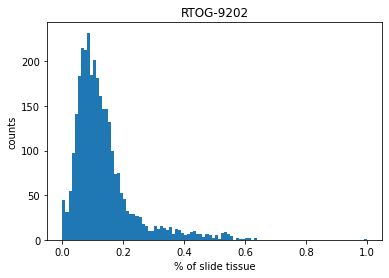

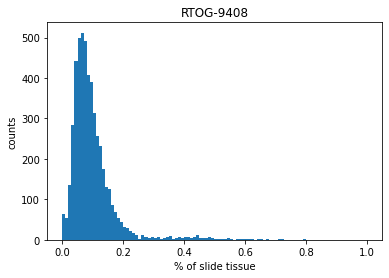

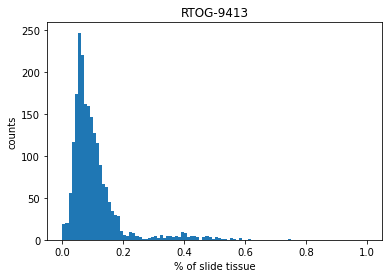

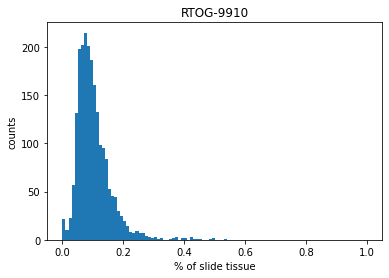

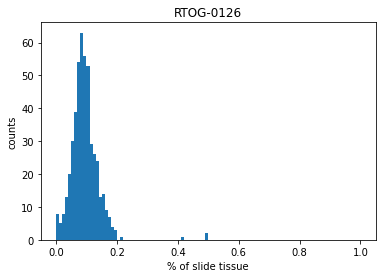

In [39]:
for study, study_percentages in percentages.items():
#     sns.histplot([x[0] for x in study_percentages], bins=100, binwidth=0.01)
    plt.hist([x[0] for x in study_percentages], range=(0,1), bins=100)
    plt.title(study)
    plt.ylabel("counts")
    plt.xlabel("% of slide tissue")
    plt.show()

In [106]:
def get_gleason_scores(patients, case_df):
    gleason_scores = []
    for patient in patients:
        patient_df = case_df.loc[case_df.cn_deidentified == patient]
        gleason_scores += list(patient_df.gleason_primary)
    return gleason_scores

for study, study_percentages in percentages.items():
    total_patches = sum([x[2] for x in study_percentages])
    turps_patches = sum([x[2] if x[0] > 0.3 else 0 for x in study_percentages])
    turps_slides = sum([x[0] > 0.3 for x in study_percentages])
    total_slides = len(study_percentages)
    
    study_slide_df = slide_df_dict[study]
    turp_patients = []
    normal_patients = []
    for percentage, slide, _, _ in study_percentages:
        patient_df = study_slide_df.loc[study_slide_df.image_id == slide]
        if percentage > 0.3:
            turp_patients += [list(patient_df.cn_deidentified)][0]
        else:
            normal_patients += [list(patient_df.cn_deidentified)][0]
    turp_patients = list(set(turp_patients))        
    normal_patients = list(set(normal_patients))        
    turp_gleason = get_gleason_scores(turp_patients, case_df_dict[study])
    normal_gleason = get_gleason_scores(normal_patients, case_df_dict[study])
    
    
    
    print(study)
    print("total tissue patches: {:,}, of which {:,} in TURPS slides.".format(total_patches, turps_patches))
    print("Percentage of tissue patches in turps: {}%".format(round(turps_patches/total_patches*100,1)))
    print("total slides: {}, turps slides: {}, percentage of slides from TURPS: {}".format(total_slides, turps_slides, round(turps_slides/total_slides*100,1)))
    print("TURPS slides per patient: {}, non-turp slides per patient: {}".format((round(turps_slides/len(turp_patients),2)), round((total_slides - turps_slides) / len(normal_patients),2)))
#     print(sorted(Counter(turp_gleason).items(), reverse=True))
#     plt.hist(normal_gleason)
#     plt.hist(turp_gleason)

    plt.show()
    print()
    
            

RTOG-9202
total tissue patches: 2,169,803, of which 815,615 in TURPS slides.
Percentage of tissue patches in turps: 37.6%
total slides: 3132, turps slides: 226, percentage of slides from TURPS: 7.2
TURPS slides per patient: 3.7, non-turp slides per patient: 2.99

RTOG-9408
total tissue patches: 2,129,712, of which 579,621 in TURPS slides.
Percentage of tissue patches in turps: 27.2%
total slides: 5055, turps slides: 147, percentage of slides from TURPS: 2.9
TURPS slides per patient: 2.88, non-turp slides per patient: 3.72

RTOG-9413
total tissue patches: 1,355,434, of which 358,904 in TURPS slides.
Percentage of tissue patches in turps: 26.5%
total slides: 2065, turps slides: 93, percentage of slides from TURPS: 4.5
TURPS slides per patient: 4.23, non-turp slides per patient: 3.07

RTOG-9910
total tissue patches: 786,148, of which 88,864 in TURPS slides.
Percentage of tissue patches in turps: 11.3%
total slides: 2121, turps slides: 26, percentage of slides from TURPS: 1.2
TURPS slides 

In [10]:
to_label_9202 = [x[1] for x in percentages["RTOG-9202"] if x[0]>0.25]

annotations_9202 = annotate(
  to_label_9202,
  options=['TURPS', 'normal'],
  display_fn=lambda filename: display(get_thumbnail(filename, "RTOG-9202").resize((300,300)))
)

In [9]:
to_label_9408 = [x[1] for x in percentages["RTOG-9408"] if x[0] > 0.22]

annotations_9408 = annotate(
  to_label_9408,
  options=['TURPS', 'normal'],
  display_fn=lambda filename: display(get_thumbnail(filename, "RTOG-9408").resize((300,300)))
)

In [8]:
to_label_9413 = [x[1] for x in percentages["RTOG-9413"] if x[0]>0.22]

annotations_9413 = annotate(
  to_label_9413,
  options=['TURPS', 'normal'],
  display_fn=lambda filename: display(get_thumbnail(filename, "RTOG-9413").resize((300,300)))
)

In [6]:
to_label_9910 = [x[1] for x in percentages["RTOG-9910"] if x[0]>0.22]

annotations_9910 = annotate(
  to_label_9910,
  options=['TURPS', 'normal'],
  display_fn=lambda filename: display(get_thumbnail(filename, "RTOG-9910").resize((300,300)))
)

In [7]:
to_label_0126 = [x[1] for x in percentages["RTOG-0126"] if x[0]>0.22]

annotations_0126 = annotate(
  to_label_0126,
  options=['TURPS', 'normal'],
  display_fn=lambda filename: display(get_thumbnail(filename, "RTOG-0126").resize((300,300)))
)

In [129]:
annotations_0126

,example,changed,label
0,115255.pkl,True,TURPS
1,114980.pkl,True,TURPS
2,115001.pkl,True,TURPS


In [136]:
unlabelled_0126 = [x[1] for x in percentages["RTOG-0126"] if x[0]<=0.22]
unlabelled_9408 = [x[1] for x in percentages["RTOG-9408"] if x[0]<=0.22]
unlabelled_9413 = [x[1] for x in percentages["RTOG-9413"] if x[0]<=0.22]
unlabelled_9910 = [x[1] for x in percentages["RTOG-9910"] if x[0]<=0.22]
unlabelled_9202 = [x[1] for x in percentages["RTOG-9202"] if x[0]<=0.25]



In [142]:
save_dir="/export/home/rtog_TURPS/"

def save_unlabelled_df(unlabelled_data, annotations, save_path):
    unlabelled_df =  pd.DataFrame(data={"example":unlabelled_data, "changed":[False]*len(unlabelled_data), "label":["normal"]*len(unlabelled_data)})
    df = pd.concat([annotations, unlabelled_df], ignore_index=True)
    df.to_csv(save_path)
    return df
test_df = save_unlabelled_df(unlabelled_0126, annotations_0126, save_dir + "RTOG-0126.csv")
test_df = save_unlabelled_df(unlabelled_9910, annotations_9910, save_dir + "RTOG-9910.csv")
test_df = save_unlabelled_df(unlabelled_9408, annotations_9408, save_dir + "RTOG-9408.csv")
test_df = save_unlabelled_df(unlabelled_9413, annotations_9413, save_dir + "RTOG-9413.csv")
test_df = save_unlabelled_df(unlabelled_9202, annotations_9202, save_dir + "RTOG-9202.csv")